# Plotting example with pyugrid and cartopy

In [1]:
%matplotlib inline


import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import netCDF4
import pyugrid

print('pyugrid version: {}'.format(pyugrid.__version__))
print('netCDF4 version: {}'.format(netCDF4.__version__))

pyugrid version: 0.1.7
netCDF4 version: 1.2.2


## Read connectivity array using pyugrid

### FVCOM example

(pyugrid reads the whole grid in to memory at once.)

In [2]:
url = 'http://testbedapps-dev.sura.org/thredds/dodsC/in/usf/fvcom/ike/ultralite/vardrag/wave/2d'

ug = pyugrid.UGrid.from_ncfile(url)

## Build the edges if they are not present in the data.

In [3]:
if not ug.edges:
    ug.build_edges()

## What's in there?

In [4]:
print('There are {} x {} nodes'.format(*ug.nodes.shape))
print('There are {} x {} edges'.format(*ug.edges.shape))
print('There are {} x {} faces'.format(*ug.faces.shape))

There are 417642 x 2 nodes
There are 1244510 x 2 edges
There are 826866 x 3 faces


In [5]:
print('First 5 elements of the connectivity array are:\n\n{}'.format(ug.faces[:5]))

First 5 elements of the connectivity array are:

[[123 122   0]
 [  0 122   1]
 [122   2   1]
 [124   2 122]
 [  2 124   3]]


In [6]:
lon = ug.nodes[:, 0]
lat = ug.nodes[:, 1]
edges = ug.edges
faces = ug.faces

## It is easier to plot using maplotlib's Triangulation object

In [7]:
triang = tri.Triangulation(lon, lat, triangles=faces)

## Plot the mesh

In [8]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m', zorder=1)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

/home/filipe/miniconda3/envs/IOOS/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


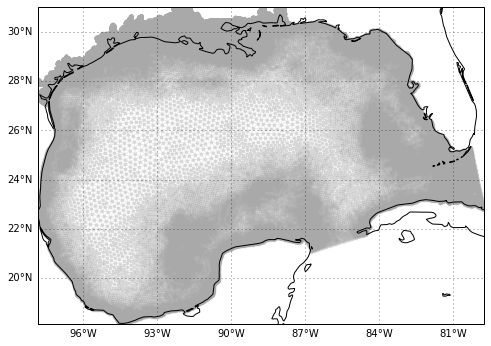

In [9]:
fig, ax = make_map()
kw = dict(marker='.', linestyle='-', alpha=0.25,
          color='darkgray', zorder=0)
lines = ax.triplot(triang, **kw)

# Read the data (pyugrid is all about the grid ;-)

In [10]:
with netCDF4.Dataset(url) as nc:
    # Last time step only.
    ele = nc['zeta'][-1, ...]

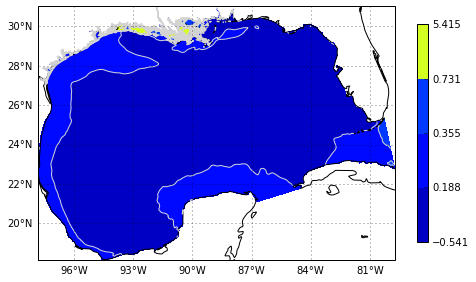

In [11]:
fig, ax = make_map()
levels = np.percentile(ele[~ele.mask], [0, 25, 50, 75, 100])

ax.tricontour(triang, ele, colors='lightgray', levels=levels)
cs = ax.tricontourf(triang, ele, levels=levels)
cbar = fig.colorbar(cs, shrink=0.65, extend='both')